In [19]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kurtosis, skew
from scipy.stats import chi2_contingency



In [20]:
# Loading the dataset
dataset = pd.read_csv('amazon_uk_products.csv')
dataset.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


#### Analyzing the Best-Seller Trends Across Product Categories
   - ##### Objective: To understand the relationship between product categories and their best-seller status

In [21]:
# Crosstab: Crosstab between products category and isBestseller will show the count of best-seller products in each category
crosstab = pd.crosstab(dataset['category'], dataset['isBestSeller'])
crosstab.head()

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3


In [22]:
# Calculating the proportions

# Adding a column for proportions of best-sellers in each category
crosstab['Proportion_BestSeller'] = crosstab[True] / (crosstab[True] + crosstab[False])

# Sorrting the categories y proportion fo best-sellers in desc. order
sorted_crosstab = crosstab.sort_values(by='Proportion_BestSeller', ascending = False)
sorted_crosstab


isBestSeller,False,True,Proportion_BestSeller
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686
Mobile Phone Accessories,248,11,0.042471
Power & Hand Tools,8353,306,0.035339
...,...,...,...
"CD, Disc & Tape Players",8798,0,0.000000
General Music-Making Accessories,259,0,0.000000
Snowboard Boots,1449,0,0.000000


#### Conduting Chi-Square test

In [23]:
# Contingency table
contingency = pd.crosstab(dataset['category'], dataset['isBestSeller'])

# Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-square Statistic: {chi2:.4f}, p-value: {p:.4f}, DoF: {dof}")


Chi-square Statistic: 36540.2027, p-value: 0.0000, DoF: 295


##### Compute Cramér's V to understand the strength of association between best-seller status and category.


In [24]:
def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n* (min(r,k)-1)))

cramers_v_score = cramers_v(contingency)
print(f"Cramer's V: {cramers_v_score:.4f}")

Cramer's V: 0.1223


#### Visualization: 
- ##### Visualize the relationship between product categories and the best-seller status using a stacked bar chart.


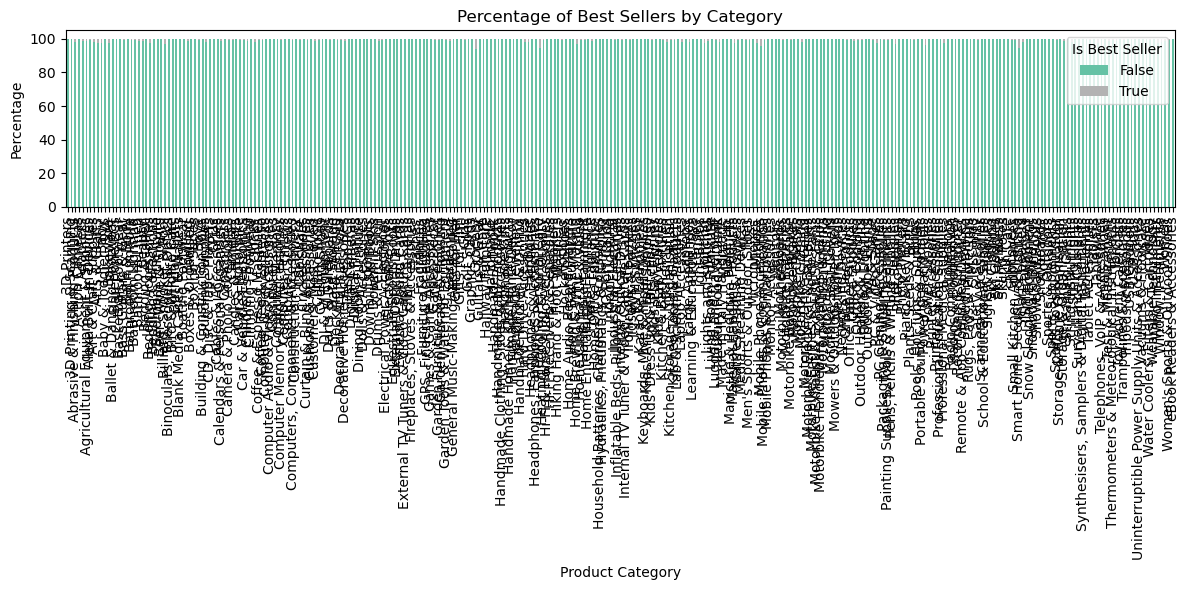

In [25]:
# Stacked bar chart
crosstab_plot = pd.crosstab(dataset['category'], dataset['isBestSeller'], normalize='index') * 100
crosstab_plot.plot(kind='bar', stacked=True, figsize=( 12, 6), colormap='Set2')

plt.title('Percentage of Best Sellers by Category')
plt.xlabel('Product Category')
plt.ylabel('Percentage')
plt.legend(title = 'Is Best Seller', loc='upper right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Part 2: Exploring Product Prices and Ratings Across Categories and Brands


In [26]:
# Extracting the price column
prices =dataset['price']
prices.head()

0    21.99
1    23.99
2    21.99
3    31.99
4    17.99
Name: price, dtype: float64

In [27]:
# Calculating Q1, Q2 and IQR
q1 = prices.quantile(0.25)
q3 = prices.quantile(0.75)
iqr = q3 - q1

print(f'Q1: £{q1:.2f}')
print(f'Q3: £{q3:.2f}')
print(f'IQR: £{iqr:.2f}')


Q1: £9.99
Q3: £45.99
IQR: £36.00


In [28]:
# Defining oulier thershold
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f'Lower bound: £{lower_bound:.2f}')
print(f'Upper bound: £{upper_bound:.2f}')


Lower bound: £-44.01
Upper bound: £99.99


In [17]:
# Filtering the outliers from the dataset

# Create a mask to exclude outliers
filtered_data = dataset[(prices >= lower_bound) & (prices <= upper_bound)]

# Verify the filtered dataset
print(f"Original dataset size: {len(dataset)}")
print(f"Filtered dataset size: {len(filtered_data)}")
print(f"Outliers removed: {len(dataset) - len(filtered_data)}")


Original dataset size: 2443651
Filtered dataset size: 2115963
Outliers removed: 327688


In [29]:
# Filtering top 20 categories by count
top_20_categories = dataset['category'].value_counts().head(20).index
filtered_data = dataset[dataset['category'].isin(top_20_categories)]


C:\Users\jugal\AppData\Local\Temp\ipykernel_27056\2980724575.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


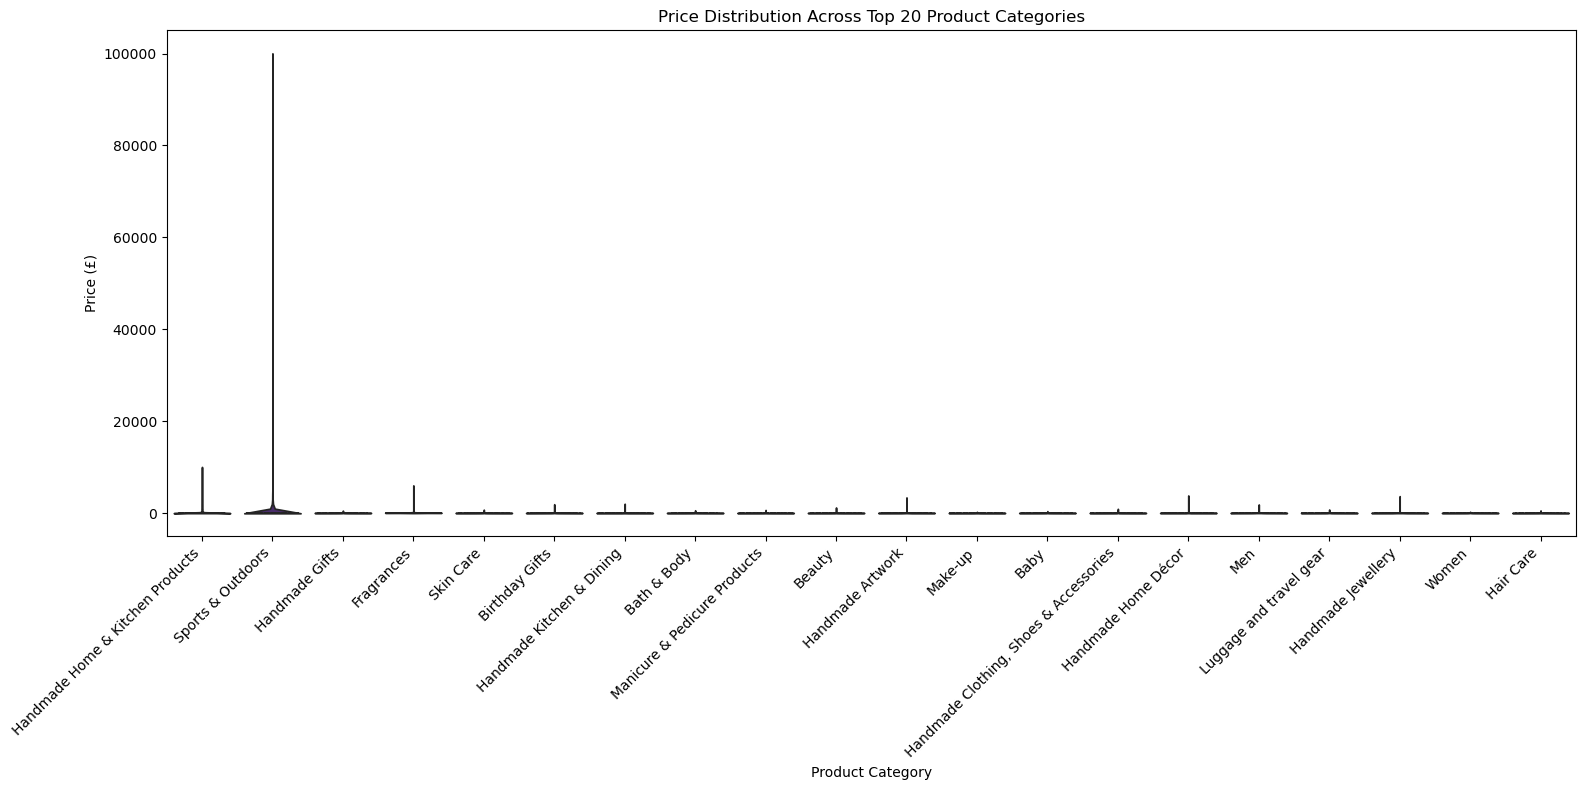

In [32]:
# Violin plot
plt.figure(figsize=(16, 8))
sns.violinplot(
    x='category',
    y='price',
    data=filtered_data,
    density_norm='width',
    inner='quartile',
    palette='viridis',
    legend = False
)
plt.title('Price Distribution Across Top 20 Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Price (£)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Insights
- ###### Highest Median Price: Identify the category where the thickest horizontal line (median) is positioned highest on the y-axis (price).

- ###### Distribution Shape: Wider sections of the violin indicate higher density of products in that price range.

#### Bar chart

In [33]:
# Grouping the category and calculate mean price
avg_prices = dataset.groupby('category')['price'].mean().sort_values(ascending=False).head(10)
avg_prices

category
Laptops                       1087.987827
3D Printers                   1018.036129
Desktop PCs                    926.816064
Home Office Furniture          622.135898
Test & Measurement             559.382973
Home Audio Record Players      529.665585
CPUs                           514.519317
Digital Cameras                496.156185
Material Handling Products     487.191813
Graphics Cards                 444.746827
Name: price, dtype: float64

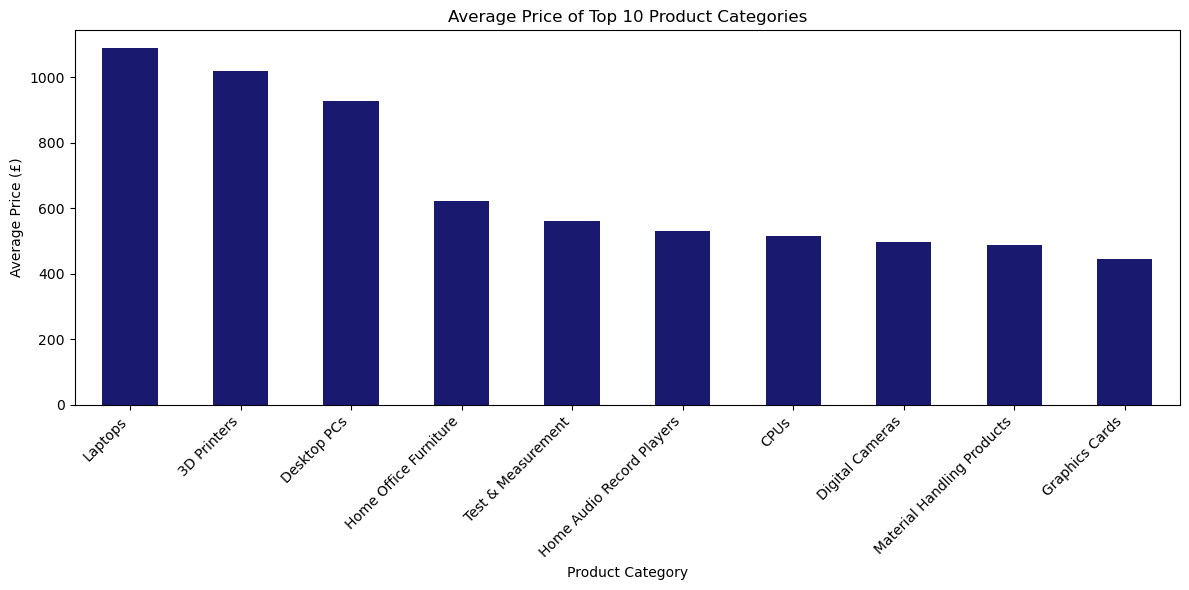

In [42]:
# Bar chart
plt.figure(figsize=(12, 6))
avg_prices.plot(kind='bar', color='midnightblue') 
plt.title('Average Price of Top 10 Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Average Price (£)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### Insights
- ###### Highest Average Price: The tallest bar corresponds to the category with the highest average price.

#### Box plots

In [ ]:
# Filtering top 10 category by count
top_10_categories = dataset['category'].value_counts().head(10).index
filtered_reviews = dataset[
    (dataset['category'].isin(top_10_categories)) &
    (dataset['stars'].notna())  # Exclude rows with missing ratings
]

C:\Users\jugal\AppData\Local\Temp\ipykernel_27056\125526459.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='stars', data=filtered_reviews, palette='Set2')


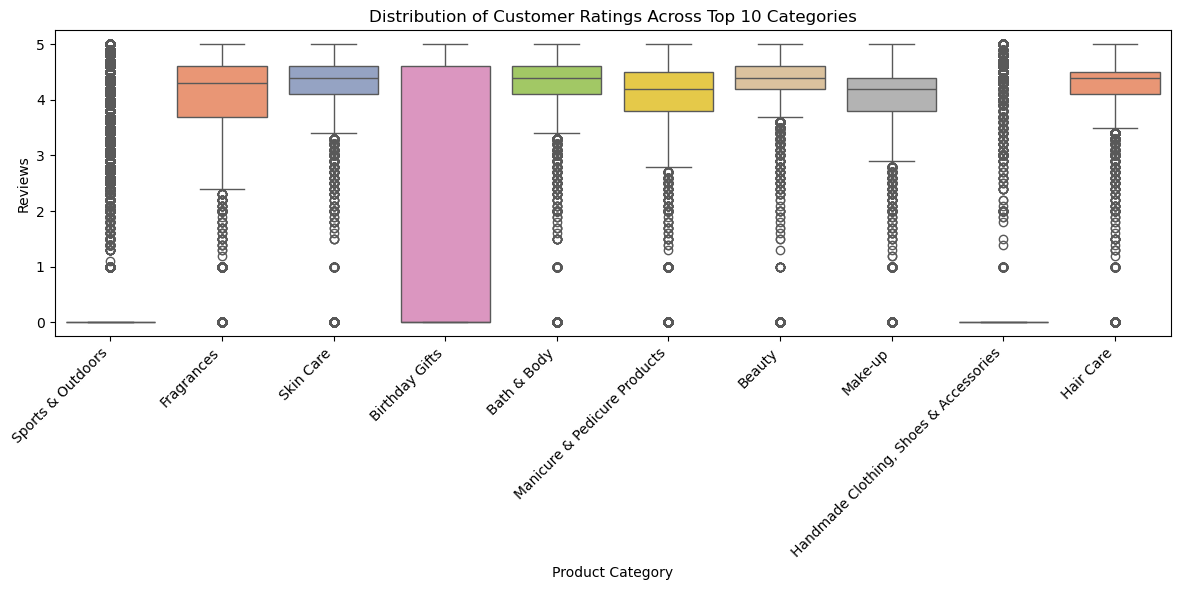

In [59]:
# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='stars', data=filtered_reviews, palette='Set2')
plt.title('Distribution of Customer Ratings Across Top 10 Categories')
plt.xlabel('Product Category')
plt.ylabel('Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### Insights
- ###### Highest Median Rating: The category with the median line (inside the box) closest to 5.0.

- ###### Outliers: Dots beyond the whiskers indicate unusually low or high ratings.

#### Part 3: Investigating the Interplay Between Product Prices and Ratings


##### Correlation coefficient

In [ ]:
#1. Checking the datset to see if there is any missing data
dataset.isna().sum()

uid                  0
asin                 0
title                0
stars                0
reviews              0
price                0
isBestSeller         0
boughtInLastMonth    0
category             0
dtype: int64

In [61]:
# Correlation between price and stars
correlation = dataset['price'].corr(dataset['stars'])
correlation

-0.12490673262148641

###### Based on the computed result, value is near to -1 which indicates that the higher prices tends to have lower ratings

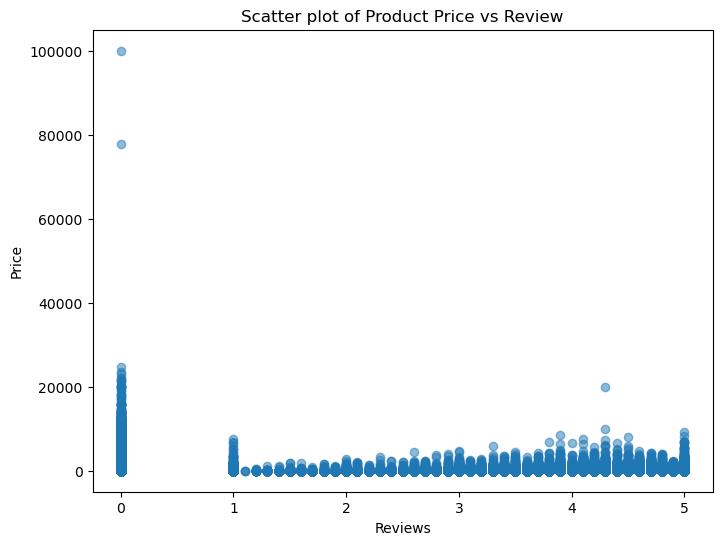

In [65]:
# Visualization

# 1. Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(dataset['stars'], dataset['price'], alpha=0.5)
plt.title('Scatter plot of Product Price vs Review')
plt.xlabel('Reviews')
plt.ylabel('Price')
plt.show()

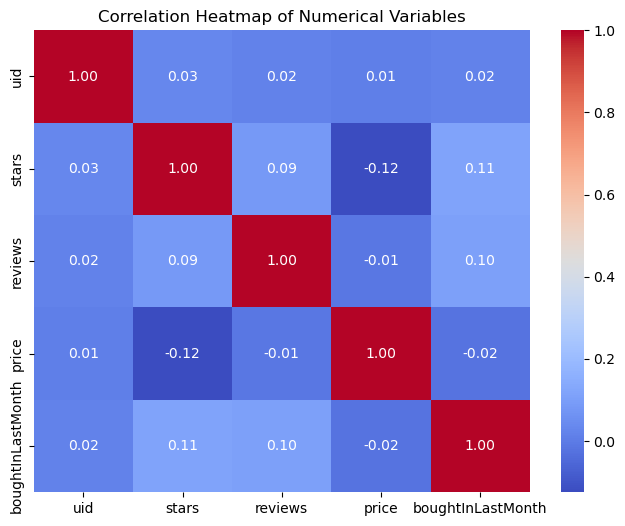

In [67]:
# Correlation heatmap
# Selecting only numeric columns
numeric_df = dataset.select_dtypes(include=np.number)

# Computing the correlation matrix
corr_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()


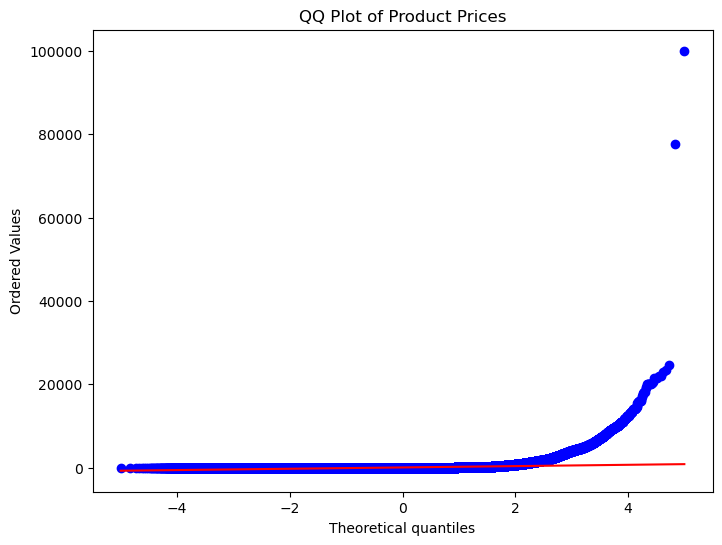

In [68]:
# QQ plot

plt.figure(figsize=(8, 6))
stats.probplot(dataset['price'], dist="norm", plot=plt)
plt.title('QQ Plot of Product Prices')
plt.show()


Category Focus: Sellers should concentrate on popular categories with proven demand but also identify niche markets where they can differentiate themselves.

Customer-Centric Approach: prioritize product quality and customer service, as ratings are not directly tied to price. Address negative reviews, and actively engage with customers to build trust and loyalty.

Data-Driven Pricing: Base pricing strategies on the competitive landscape and perceived value rather than solely on target rating levels.